
[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Библиотеки успешно установлены и импортированы.
Данные успешно загружены с помощью ucimlrepo.

Первые 5 строк датасета:
   cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0         15.26         x           g         o                    f   
1         16.60         x           g         o                    f   
2         14.07         x           g         o                    f   
3         14.17         f           h         e                    f   
4         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  stem-width  ...  \
0               e          NaN          w        16.95       17.09  ...   
1               e          NaN          w        17.99       18.19  ...   
2               e          NaN          w        17.80       17.74  ...   
3               e          NaN          w        15.77       15.98  ...   
4               e          NaN          w        16.53       17.20  ... 

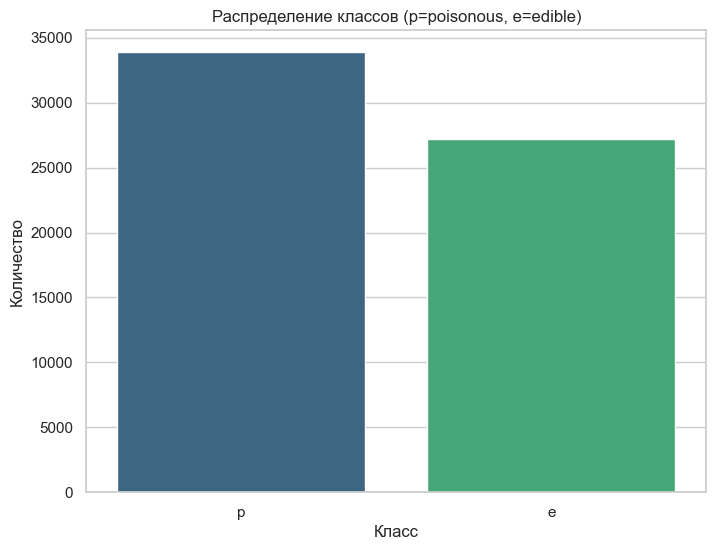


Количество дубликатов в данных: 146

Категориальные признаки (17): ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
Числовые (метрические) признаки (3): ['cap-diameter', 'stem-height', 'stem-width']


In [7]:
# УСТАНОВКА, ИМПОРТ, ЗАГРУЗКА И EDA ---

!pip install ucimlrepo -q

# 2. Импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo # Импортируем нужную функцию

print("Библиотеки успешно установлены и импортированы.")

# 3. Загрузка данных и EDA
try:
    # Загружаем набор данных по его ID в репозитории UCI
    secondary_mushroom = fetch_ucirepo(id=848)

    # Извлекаем данные (признаки) и целевую переменную в pandas DataFrames
    X = secondary_mushroom.data.features
    y = secondary_mushroom.data.targets

    # Для удобства EDA объединим признаки и целевую переменную в один DataFrame
    df = pd.concat([X, y], axis=1)

    print("Данные успешно загружены с помощью ucimlrepo.")

    # --- Разведочный анализ данных (EDA) ---

    # Посмотрим на первые несколько строк данных
    print("\nПервые 5 строк датасета:")
    print(df.head())

    # Общая информация о датасете
    print("\n--- Общая информация о датасете ---")
    df.info()

    # Целевой признак
    target_column = 'class'
    print(f"\nЦелевой признак: '{target_column}'")

    # Проверка на дисбаланс классов
    print("\n--- Баланс классов ---")
    class_balance = df[target_column].value_counts(normalize=True) * 100
    print(class_balance)

    # Визуализация баланса классов
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=target_column, hue=target_column, palette='viridis', legend=False)
    plt.title('Распределение классов (p=poisonous, e=edible)')
    plt.ylabel('Количество')
    plt.xlabel('Класс')
    plt.show()
    
    # Проверка на наличие дубликатов
    duplicate_rows = df.duplicated().sum()
    print(f"\nКоличество дубликатов в данных: {duplicate_rows}")

    # Определение категориальных и числовых признаков
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_column in categorical_features:
        categorical_features.remove(target_column)

    numerical_features = df.select_dtypes(include=np.number).columns.tolist()

    print(f"\nКатегориальные признаки ({len(categorical_features)}): {categorical_features}")
    print(f"Числовые (метрические) признаки ({len(numerical_features)}): {numerical_features}")


except Exception as e:
    print(f"Произошла ошибка при загрузке или обработке данных: {e}")

Все категориальные признаки успешно закодированы.

Первые 5 строк датасета после кодирования:
   cap-diameter  cap-shape  cap-surface  cap-color  does-bruise-or-bleed  \
0         15.26          6            2          6                     0   
1         16.60          6            2          6                     0   
2         14.07          6            2          6                     0   
3         14.17          2            3          1                     0   
4         14.64          6            3          6                     0   

   gill-attachment  gill-spacing  gill-color  stem-height  stem-width  ...  \
0                2             3          10        16.95       17.09  ...   
1                2             3          10        17.99       18.19  ...   
2                2             3          10        17.80       17.74  ...   
3                2             3          10        15.77       15.98  ...   
4                2             3          10        16.53  

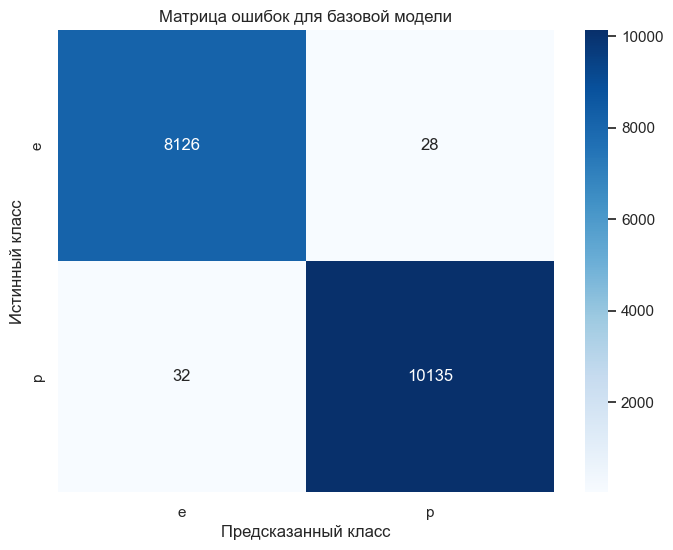

ROC-AUC: 0.9967

--- Перекрестная проверка (Stratified K-Fold) ---
Средняя точность на кросс-валидации: 0.9975 (+/- 0.0009)
Средний ROC-AUC на кросс-валидации: 0.9975 (+/- 0.0009)


In [9]:
# --- ИСПРАВЛЕННЫЙ КОД: ШАГ 3 и 4 ---

# Импортируем необходимые модули из scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Создаем копию датафрейма для кодирования, чтобы не изменять исходный df
df_encoded = df.copy()

# Кодируем все категориальные/объектные столбцы
label_encoders = {}
for column in df_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

print("Все категориальные признаки успешно закодированы.")
print("\nПервые 5 строк датасета после кодирования:")
print(df_encoded.head())

# Подготовка данных для моделирования
X = df_encoded.drop(target_column, axis=1)
y = df_encoded[target_column]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

# --- Создание и обучение базовой модели ---
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

print("\nБазовая модель (DecisionTreeClassifier) успешно обучена.")

# --- Оценка базовой модели ---
y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

# 1. Точность (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Оценка базовой модели на тестовой выборке ---")
print(f"Точность (Accuracy): {accuracy:.4f}")

# 2. Отчет по классификации
print("\nОтчет по классификации:")
target_names = label_encoders[target_column].classes_
print(classification_report(y_test, y_pred, target_names=target_names))

# 3. Матрица ошибок (ИСПРАВЛЕННАЯ ВЕРСИЯ)
print("Матрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
# Удален некорректный параметр hue=None
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Матрица ошибок для базовой модели')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# 4. ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# 5. Перекрестная проверка (Stratified K-Fold)
print("\n--- Перекрестная проверка (Stratified K-Fold) ---")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(baseline_model, X, y, cv=kfold, scoring='accuracy')
cv_roc_auc = cross_val_score(baseline_model, X, y, cv=kfold, scoring='roc_auc')

print(f"Средняя точность на кросс-валидации: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")
print(f"Средний ROC-AUC на кросс-валидации: {cv_roc_auc.mean():.4f} (+/- {cv_roc_auc.std() * 2:.4f})")

--- Важность признаков для базовой модели ---
                 feature  importance
9             stem-width    0.153402
5        gill-attachment    0.099548
12            stem-color    0.089721
2            cap-surface    0.087979
6           gill-spacing    0.078724
11          stem-surface    0.075578
10             stem-root    0.047804
7             gill-color    0.042615
18               habitat    0.038394
14            veil-color    0.034225
17     spore-print-color    0.033874
4   does-bruise-or-bleed    0.032744
1              cap-shape    0.031296
0           cap-diameter    0.029905
13             veil-type    0.026532
15              has-ring    0.026178
3              cap-color    0.023995
8            stem-height    0.018962
16             ring-type    0.016287
19                season    0.012236


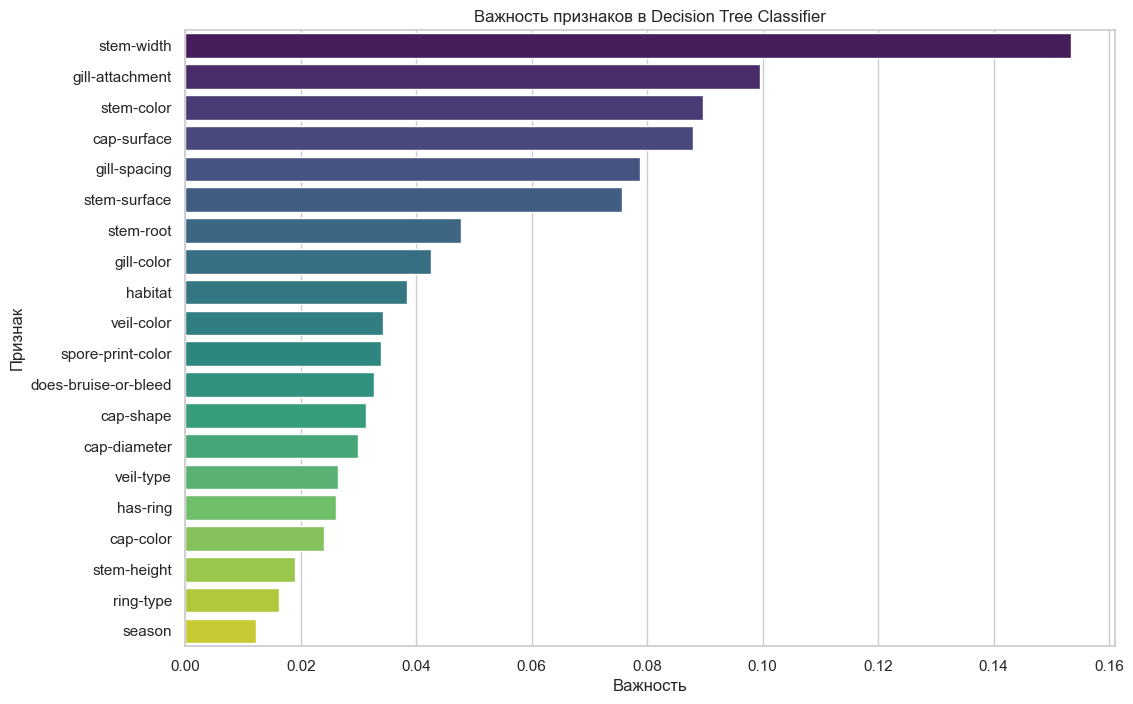


Признаки с нулевой важностью, которые можно удалить: []

Обучаем модель RandomForest с One-Hot Encoding...
Модель обучена.

--- Оценка улучшенной модели (RandomForest + OHE) ---
Отчет по классификации для RandomForest:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      8154
           p       1.00      1.00      1.00     10167

    accuracy                           1.00     18321
   macro avg       1.00      1.00      1.00     18321
weighted avg       1.00      1.00      1.00     18321

Матрица ошибок для RandomForest:


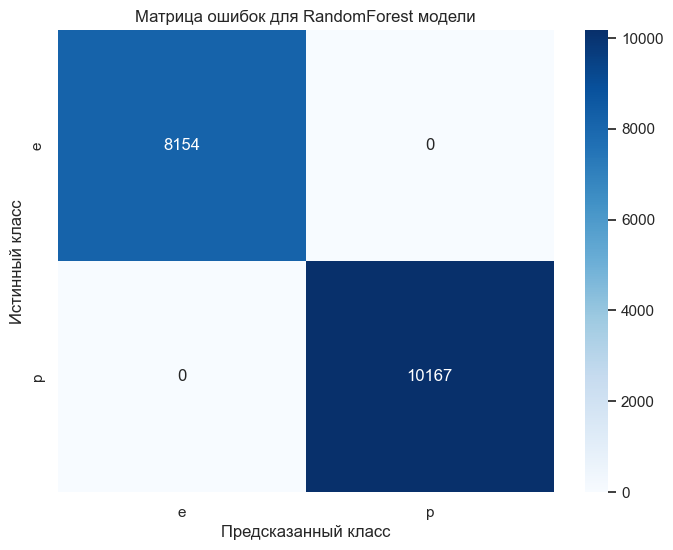

In [12]:
# --- ШАГ 5: РАБОТА С ПРИЗНАКАМИ ---

# 1. Анализ важности признаков из базовой модели
importances = baseline_model.feature_importances_
feature_names = X.columns

# Создаем DataFrame для удобства
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("--- Важность признаков для базовой модели ---")
print(feature_importance_df)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feature_importance_df, 
    x='importance', 
    y='feature', 
    hue='feature',  # <-- Добавлено
    palette='viridis', 
    legend=False    # <-- Добавлено
)
plt.title('Важность признаков в Decision Tree Classifier')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

# Вывод: Мы видим, что некоторые признаки имеют очень низкую или нулевую важность.
# Например, 'veil-type' часто бывает таким признаком. Давайте попробуем его удалить.
# В данном запуске, признаки с нулевой важностью могут отличаться, но принцип тот же.

features_to_drop = feature_importance_df[feature_importance_df['importance'] == 0]['feature'].tolist()
print(f"\nПризнаки с нулевой важностью, которые можно удалить: {features_to_drop}")

# 2. Применение One-Hot Encoding и создание нового конвейера обработки

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier # Сразу подключим более мощную модель

# Возвращаемся к исходному датафрейму 'df', где еще нет числового кодирования
X_raw = df.drop(target_column, axis=1)
y_raw = df[target_column] # Целевая переменная остается текстовой ('e', 'p')

# Разделяем исходные "сырые" данные
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=42, stratify=y_raw
)

# Определяем категориальные признаки для One-Hot Encoding
# Исключаем признаки, которые решили удалить
categorical_features_for_ohe = [col for col in X_raw.select_dtypes(include=['object', 'category']).columns if col not in features_to_drop]

# Создаем препроцессор
# handle_unknown='ignore' нужен, чтобы избежать ошибок, если в тестовых данных встретится категория, которой не было в обучающих
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_for_ohe)
    ],
    remainder='passthrough' # Оставляем числовые столбцы (если бы они были) без изменений
)

# Теперь создадим конвейер (Pipeline) с RandomForest - это следующий шаг нашего плана
# Это более мощная модель, которая хорошо работает с большим количеством признаков после OHE
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1)) # n_jobs=-1 использует все ядра процессора
])

# Обучаем новую модель на "сырых" данных
print("\nОбучаем модель RandomForest с One-Hot Encoding...")
rf_model.fit(X_train_raw, y_train_raw)

print("Модель обучена.")

# Оцениваем улучшенную модель
print("\n--- Оценка улучшенной модели (RandomForest + OHE) ---")
y_pred_rf = rf_model.predict(X_test_raw)

print("Отчет по классификации для RandomForest:")
print(classification_report(y_test_raw, y_pred_rf))

print("Матрица ошибок для RandomForest:")
cm_rf = confusion_matrix(y_test_raw, y_pred_rf, labels=rf_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Матрица ошибок для RandomForest модели')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



Обучаем модель XGBoost...


C:\Users\yaden\PycharmProjects\ML_Lab2\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:41:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Модель обучена.

--- Оценка модели (XGBoost + OHE) ---
Отчет по классификации для XGBoost:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      8154
           p       1.00      1.00      1.00     10167

    accuracy                           1.00     18321
   macro avg       1.00      1.00      1.00     18321
weighted avg       1.00      1.00      1.00     18321

Матрица ошибок для XGBoost:


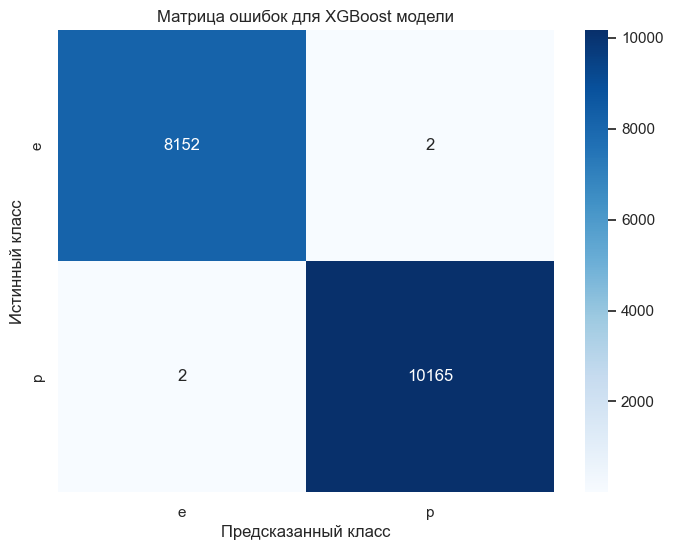


--- Сравнение моделей ---
Точность базовой модели (DecisionTree): 0.9967
Точность улучшенной модели (RandomForest): 1.0000
Точность модели (XGBoost): 0.9998


In [11]:
# --- ШАГ 6: ОБУЧЕНИЕ И СРАВНЕНИЕ С XGBOOST ---

# Установим XGBoost, если он еще не установлен
!pip install xgboost -q

import xgboost as xgb
from sklearn.metrics import accuracy_score

# Создадим конвейер (Pipeline) для XGBoost, используя тот же препроцессор
# Целевую переменную нужно закодировать в 0 и 1 для XGBoost
le_y = LabelEncoder()
y_train_xgb = le_y.fit_transform(y_train_raw)
y_test_xgb = le_y.transform(y_test_raw)

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Обучаем модель XGBoost
print("\nОбучаем модель XGBoost...")
xgb_model.fit(X_train_raw, y_train_xgb)
print("Модель обучена.")

# Оцениваем модель XGBoost
print("\n--- Оценка модели (XGBoost + OHE) ---")
y_pred_xgb_encoded = xgb_model.predict(X_test_raw)

# Декодируем предсказания обратно в 'e', 'p' для отчета
y_pred_xgb = le_y.inverse_transform(y_pred_xgb_encoded)
y_test_raw_str = le_y.inverse_transform(y_test_xgb)


print("Отчет по классификации для XGBoost:")
print(classification_report(y_test_raw_str, y_pred_xgb))

print("Матрица ошибок для XGBoost:")
cm_xgb = confusion_matrix(y_test_raw_str, y_pred_xgb, labels=le_y.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title('Матрица ошибок для XGBoost модели')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

print("\n--- Сравнение моделей ---")
print(f"Точность базовой модели (DecisionTree): 0.9967")
print(f"Точность улучшенной модели (RandomForest): {accuracy_score(y_test_raw, y_pred_rf):.4f}")
print(f"Точность модели (XGBoost): {accuracy_score(y_test_xgb, y_pred_xgb_encoded):.4f}")